<a href="https://colab.research.google.com/github/bradleywjenks/CIVE_70019_70057/blob/main/notebooks/model_calibration_coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter estimation for hydraulic model calibration and fault detection
# Eddy Mayar Ariss
# CID 01733690

### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

### Preamble
You have been tasked with the evaluation and calibration of the hydraulic model of EXNING, a district metered area (DMA) in Anglian Water's (AW) water distribution network. To achieve this, you have been provided:
* a hydraulic model of the EXNING DMA, in use by Anglian Water in early 2019 (no record of recent calibration),
* pipe groups (based on material & age) and corresponding ranges of H-W coefficients,
* hourly loading conditions (demands, reservoir heads) and head measurements covering a period of 4 days in December 2019.

The objective of the coursework is to prepare a short calibration report for AW by completing the tasks below and answering the questions (max. 100-150 words per question) based on your results. Don't forget to include titles, labels and legends in your plots, and watch for significant figures in your reporting!

You have also been provided the following information about EXNING:
* EXNING is part of a larger system of cascading DMAs: EXNING is fed by the NEWSEV DMA and feeds into the BURWEL DMA.
* According to AW's existing records, EXNING contains mostly old, cast iron pipes.
* The "reservoir" head  and total demand of EXNING are derived from flow and pressure sensors at the DMA inlet (& outlet).
* Node elevations have been updated in the provided model following a GPS survey of sensor locations.

First, we must clone the GitHub repository and install dependencies (only run this once).

In [1]:
# run this cell once
import sys
import os

In [2]:
# load packages
import numpy as np
from numpy import linalg as la
import networkx as nx
import pandas as pd
import wntr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from datetime import datetime, timedelta
import cvxpy as cp
import warnings
warnings.filterwarnings('ignore')

# improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Load network properties and operational data

Load functions created in previous assignments.

In [3]:
# load functions from src folder
if 'google.colab' in sys.modules:
    sys.path.append('/content/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *
else:
    sys.path.append('/Users/mayar/Desktop/ICL/4Y/STOIANOW/coursework/functions/')
    from general_functions import *
    from hydraulic_functions import *

Load network .inp file and operational data from the module repository's data directory.

In [4]:
if 'google.colab' in sys.modules:
    # if run in Google Colab
    data_dir = '/content/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/content/CIVE_70019_70057/data/networks/'
else:
    # replace with local directory
    data_dir = './parameter_estimation/'
    net_dir = './networks/'

net_name = 'exning.inp'
data_name = 'exning_coursework_dataset.npy'

# load operational data
data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()
h_data = data['h_data']
sensor_idx = data['sensor_idx'] - 1 # matlab to python index offset
d_data = data['d']
h0_data = data['h0'].reshape(-1, 1).T

# load network properties
wdn = load_network_data(os.path.join(net_dir, net_name))
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df

Plot sensor nodes in network. We provide a plotting function below.

In [5]:
#### DO NOT CHANGE THIS ####
# network plotting function
def plot_network(wdn, sensor_idx, vals=None, highlight_valves=None):

    # unload data
    link_df = wdn.link_df
    node_df = wdn.node_df
    net_info = wdn.net_info
    h0_df = wdn.h0_df

    # draw network
    uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
    pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}
    nx.draw(uG, pos, node_size=20, node_shape='o')

    # draw reservoir
    nx.draw_networkx_nodes(uG, pos, nodelist=net_info['reservoir_names'], node_size=100, node_shape='s', node_color='black')

    # draw sensor nodes
    sensor_names = [net_info['junction_names'][i] for i in sensor_idx]
    nx.draw_networkx_nodes(uG, pos, sensor_names, node_size=100, node_shape='o', node_color='red', edgecolors='white')

    # reservoir labels
    reservoir_labels = {node: 'Reservoir' for node in net_info['reservoir_names']}
    labels_res = nx.draw_networkx_labels(uG, pos, reservoir_labels, font_size=10, verticalalignment='top')
    for _, label in labels_res.items():
        label.set_y(label.get_position()[1] - 1500)

    # sensor labels
    sensor_labels = {node: str(idx+1) for (idx, node) in enumerate(sensor_names)}
    labels_sen = nx.draw_networkx_labels(uG, pos, sensor_labels, font_size=10, verticalalignment='bottom')
    for _, label in labels_sen.items():
        label.set_y(label.get_position()[1] + 1000)

    # plot sensor vals
    if vals is not None:

        cmap = cm.get_cmap('RdYlGn_r')

        # plot residuals
        nx.draw_networkx_nodes(uG, pos, nodelist=sensor_names, node_size=100, node_shape='o', node_color=vals, cmap=cmap, edgecolors='white')

        # create color bar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array(vals)
        colorbar = plt.colorbar(sm)
        colorbar.set_label('Mean pressure residual [m]', fontsize=10)

    # highlight link
    if highlight_valves is not None:
        nx.draw_networkx_nodes(uG, pos, highlight_valves, node_size=200, node_shape='d', node_color='limegreen', edgecolors='white')

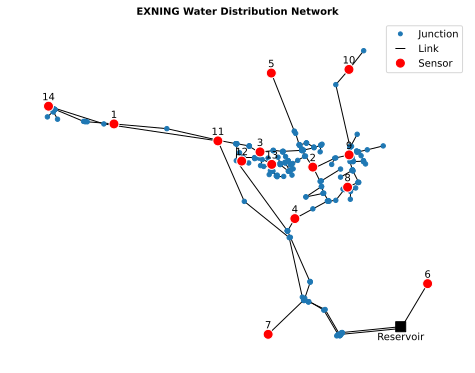

In [6]:
import matplotlib.lines as mlines

# Define the figure size
plt.figure()

# Create custom legend entries
sensor_legend = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Sensor')
node_legend = mlines.Line2D([], [], marker='o', linestyle='None', markersize=4, label='Junction')
link_legend = mlines.Line2D([], [], color='black', marker='_', linestyle='None', markersize=10, label='Link')

# Plot the network
plot_network(wdn, sensor_idx)
plt.legend(handles=[node_legend, link_legend, sensor_legend], loc='best')
plt.title('EXNING Water Distribution Network', fontsize=10, fontweight='bold')
# Display the plot
plt.show()

### Preliminary model evaluation

Simulate initial (uncalibrated) network hydraulics over 4 days. We first define a function to solve network hydraulics using the `wntr` package, which we used previously in the hyraulic modelling notebook. The following tasks are performed in this function:
- Load network properties
- Modify simulation time to match operational data
- Assign h0 data at model reservoir
- Scale and apply new demand pattern from inflow data
- Option to modify pipe roughness (or HW) coefficients

<font color="blue">NB: this is done for you below. Provided the correct inputs, you do not need to replicate this function.

In [7]:
#### DO NOT CHANGE THIS ####
# hydraulic solver function
def hydraulic_solver(inp_file, d_data, h0_data, C=None, demand=False):

    # load network from wntr
    inp_file = os.path.join(net_dir, net_name)
    wn = wntr.network.WaterNetworkModel(inp_file)

    # get network properties
    reservoir_names = wn.reservoir_name_list
    junction_names = wn.junction_name_list
    link_names = wn.link_name_list

    # modify simulation time and hydraulic time step
    nt = h0_data.shape[1]
    wn.options.time.duration = (nt - 1) * 3600
    wn.options.time.hydraulic_timestep = 3600
    wn.options.time.pattern_timestep = 3600
    wn.options.time.report_timestep = 3600

    # assign reservoir data
    for (i, name) in enumerate(reservoir_names):
        wn.add_pattern(f'h0_{i}', h0_data[i])
        reservoir = wn.get_node(name)
        reservoir.head_timeseries.base_value = 1
        reservoir.head_timeseries.pattern_name = wn.get_pattern(f'h0_{i}')

    # replace demand data
    for idx, name in enumerate(junction_names):

        if any(val != 0 for val in d_data[idx, :]):
            node = wn.get_node(name)
            d_pat = d_data[idx, :]
            wn.add_pattern('d_'+name, d_pat)

            for (i, num) in enumerate(node.demand_timeseries_list):
                if i == 0:
                    node.demand_timeseries_list[i].base_value = 1
                    node.demand_timeseries_list[i].pattern_name = 'd_'+name
                else:
                    node.demand_timeseries_list[i].base_value = None
                    node.demand_timeseries_list[i].pattern_name = None

    # assign roughness (or HW) coefficients
    if C is not None:
        for name, link in wn.links():

            # check if the link is a pipe
            if isinstance(link, wntr.network.Pipe):
                link.roughness = C[link_names.index(name)]

            # check if link is a valve
            elif isinstance(link, wntr.network.Valve):
                link.minor_loss = C[link_names.index(name)]
                link.initial_setting = C[link_names.index(name)]

    # run simulation and get results
    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()

    q_sim = results.link['flowrate'].T
    h_sim = results.node['head'].T
    h_sim = h_sim[~h_sim.index.isin(reservoir_names)] # delete reservoir nodes
    d = results.node['demand'].T
    d = d[~d.index.isin(reservoir_names)] # delete reservoir nodes


    if demand == True:
        return d.to_numpy()
    else:
        return q_sim.to_numpy(), h_sim.to_numpy()

Run simulation with initial $C_0$ values.

In [8]:
C_0 = link_df['C'].to_numpy()
q_0, h_0 = hydraulic_solver(inp_file=os.path.join(net_dir, net_name),
                            d_data=d_data,
                            h0_data=h0_data,
                            C=C_0,
                            demand=False)  # assuming demand=False as default function setting

Compare simulated heads at sensor nodes (node indices in `sensor_idx`) with the simulated heads over the 4-day period. Visualise the results with, e.g. a boxplot of pressure residuals on the test dataset.

In [9]:
print("h_data shape:", h_data.shape)
print("h_0 shape:", h_0.shape)
print("Max index in sensor_idx:", max(sensor_idx))

h_data shape: (14, 96)
h_0 shape: (290, 96)
Max index in sensor_idx: 283


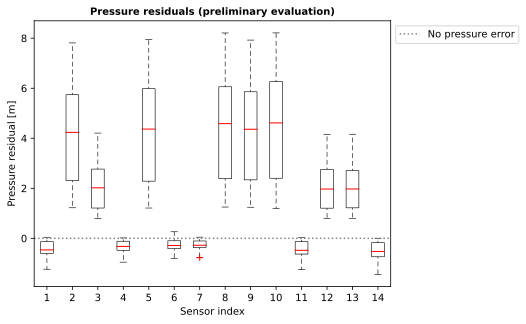

In [10]:
# compute pressure residuals

# the residuals are the differences between simulated heads (h_0) & measured heads (h_data) at sensor nodes
residuals_0 = h_0[sensor_idx, :] - h_data

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_0.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=10)
ax.set_ylabel('Pressure residual [m]', fontsize=10)

# add a dotted horizontal line at y=0 to highlight the zero residual level
ax.axhline(y=0, color='grey', linestyle='dotted', label='No pressure error')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adding the legend for the dotted line
plt.title('Pressure residuals (preliminary evaluation)', fontsize=10, fontweight='bold')
plt.show()

We code the below cell to automate the process of detecting sensor IDs with acceptable performance.

In [11]:
# initialize empty lists to hold the indices for calibrated and uncalibrated sensors
indices_calibrated = []
sensorID_calibrated = []

indices_uncalibrated = []
sensorID_uncalibrated = []

# Iterate through each set of residuals (each sensor's data)
for i in range(residuals_0.shape[0]):
    # Calculate the maximum and minimum residuals for the current sensor
    max_residual = np.max(residuals_0[i])
    min_residual = np.min(residuals_0[i])
    
    # Check if the maximum and minimum residuals are both within the range [-2, 2]
    if max_residual <= 2 and min_residual >= -2:
        # If yes, append the index to the calibrated list
        indices_calibrated.append(i)
        sensorID_calibrated.append(i+1)  # sensor ID is i+1 to take into account python indexing
    else:
        # If not, append the index to the uncalibrated list
        indices_uncalibrated.append(i)
        sensorID_uncalibrated.append(i+1)  # sensor ID is i+1 to take into account python indexing

# Printing the calibrated & uncalibrated sensors
print('Calibrated sensors are: ' + ', '.join(str(id) for id in sensorID_calibrated))
print('Uncalibrated sensors are: ' + ', '.join(str(id) for id in sensorID_uncalibrated))


Calibrated sensors are: 1, 4, 6, 7, 11, 14
Uncalibrated sensors are: 2, 3, 5, 8, 9, 10, 12, 13


Then, we plot the hourly residuals in a similar automated way. (commented out for conciseness)

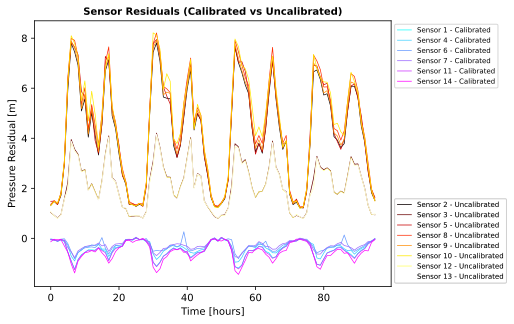

In [12]:
# # Define the colormaps for calibrated and uncalibrated sensors
# cmap_calibrated = plt.get_cmap('cool')
# cmap_uncalibrated = plt.get_cmap('hot')

# # We normalize the colors to the number of plots
# colors_calibrated = cmap_calibrated(np.linspace(0, 1, len(indices_calibrated)))
# colors_uncalibrated = cmap_uncalibrated(np.linspace(0, 1, len(indices_uncalibrated)))

# # Create legend handles and labels for calibrated sensors
# legend_handles_calibrated = []
# legend_labels_calibrated = []

# for i, color in zip(indices_calibrated, colors_calibrated):
#     line, = plt.plot(residuals_0[i], label=f"Sensor {i+1} - Calibrated", color=color, linewidth=0.7)
#     legend_handles_calibrated.append(line)
#     legend_labels_calibrated.append(f"Sensor {i+1} - Calibrated")

# # Legends handles and labels for uncalibrated sensors
# legend_handles_uncalibrated = []
# legend_labels_uncalibrated = []

# for i, color in zip(indices_uncalibrated, colors_uncalibrated):
#     line, = plt.plot(residuals_0[i], label=f"Sensor {i+1} - Uncalibrated", color=color, linewidth=0.7)
#     legend_handles_uncalibrated.append(line)
#     legend_labels_uncalibrated.append(f"Sensor {i+1} - Uncalibrated")

# plt.xlabel("Time [hours]", fontsize=10)
# plt.ylabel("Pressure Residual [m]", fontsize=10)
# plt.title("Sensor Residuals (Calibrated vs Uncalibrated)", fontsize=10, fontweight='bold')

# # Create separate legends for calibrated and uncalibrated sensors
# legend_calibrated = plt.legend(legend_handles_calibrated, legend_labels_calibrated, loc='upper left', bbox_to_anchor=(1, 1), fontsize=7)
# legend_uncalibrated = plt.legend(legend_handles_uncalibrated, legend_labels_uncalibrated, loc='lower left', bbox_to_anchor=(1, 0), fontsize=7)

# # Add both legends to the plot
# plt.gca().add_artist(legend_calibrated)
# plt.gca().add_artist(legend_uncalibrated)

# plt.show()


***
**<u>Question 1:</u>** Is the current hydraulic model of EXNING accurate according to hydraulic model calibration guidelines? Comment on the results of the preliminary model evaluation and, in particular, on
* the **sign** (i.e. are heads over or underestimated in the hydraulic simulation?) of pressure/head residuals,
* the **temporal** distribution (i.e. are the residuals time/flow dependent?) of pressure/head residuals,
* and the **spatial** distribution (i.e. are all sensors affected?) of the pressure/head residuals.

Given the information you were provided about the EXNING system and the results of the preliminary model evaluation, identify the most likely sources of model errors.

***
_Sensors 1, 4, 6, 7, 11, 14, show acceptable residuals = whiskers within ±2m H2O (Earnshaw, 1989)._

_Sensors 2, 3, 5, 8, 9, 10, 12, 13 show large positive residuals. On average, the hydraulic simulation model is overpredicting pressure heads (or underpredicting head losses) at these locations._

_There is a spatio-temporal dependency of pressure residuals, as head loss is a function of water demand, a time-dependent parameter (L/s), and pipe roughness, which varies in space. Both are the most uncertain input parameters in the hydraulic model because not directly measurable. Assuming accurate load/field and elevation data, likely sources of errors are, using the terms defined by Hall (2003):_

* _Aleatory (i.e. spatial and temporal variability in water demand)_
* _Epistemic (i.e. incomplete system knowledge):_
_Uncertainty in the hydraulic model, such as pipe roughness, local losses._
_Possible changes in network connectivity during the simulation._

The spatial and temporal patterns are visualised below:

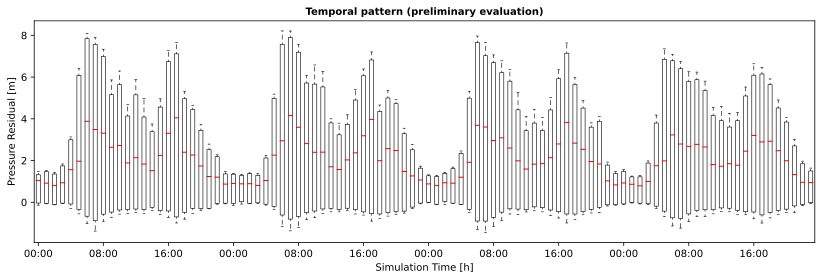

In [13]:
# Create a figure and axis for the box plots
fig, ax = plt.subplots(figsize=(14, 4))

# Create boxplots for each time step
boxplot = ax.boxplot(residuals_0, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))

# Set x-axis ticks for every 8 hours with time format
num_time_steps = residuals_0.shape[1]
hours_per_day = 24
xticks = np.arange(1, num_time_steps + 1, 8)
xtick_labels = [f"{(i % hours_per_day):02d}:00" for i in range(0, num_time_steps, 8)]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

ax.set_xlabel('Simulation Time [h]', fontsize=10)
ax.set_ylabel('Pressure Residual [m]', fontsize=10)

plt.title('Temporal pattern (preliminary evaluation)', fontsize=10, fontweight='bold')
plt.show()


_Morning and night hours => Low flow => Low residual, as head loss is a function of velocity or flow (L/s)._

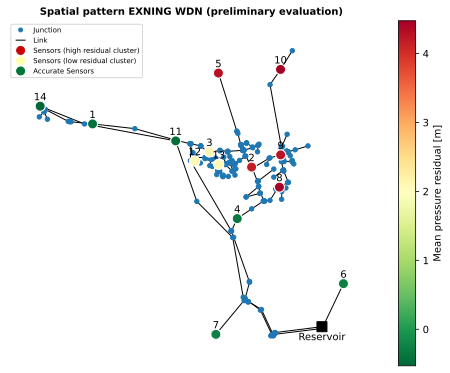

In [14]:
# Generate EXNING map to display localised issue
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import networkx as nx

# Define the figure size
plt.figure()

# Create legend entries
sensor_legendA = mlines.Line2D([], [], color=(200/255, 0/255, 5/255), marker='o', linestyle='None', markersize=8, label='Sensors (high residual cluster)')
sensor_legendB = mlines.Line2D([], [], color=(254/255, 254/255, 174/255), marker='o', linestyle='None', markersize=8, label='Sensors (low residual cluster)')
sensor_legendC = mlines.Line2D([], [], color=(0/255, 117/255, 56/255), marker='o', linestyle='None', markersize=8, label='Accurate Sensors')

node_legend = mlines.Line2D([], [], marker='o', linestyle='None', markersize=4, label='Junction')
link_legend = mlines.Line2D([], [], color='black', marker='_', linestyle='None', markersize=10, label='Link')

# Plot the network
mean_residuals_0 = np.mean(residuals_0, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_0)
plt.legend(handles=[node_legend, link_legend, sensor_legendA, sensor_legendB, sensor_legendC], loc='upper left', fontsize=7)

plt.title('Spatial pattern EXNING WDN (preliminary evaluation)', fontsize=10, fontweight='bold')
plt.show()


_Sensors (2, 5, 8, 9, 10) show larger positive residuals than (3, 12, 13). Clusters (red dots 2, 5, 8, 9, 10) & (yellow dots 3, 12, 13) have a distinct spatial separation which indicates localised issues in the system._

***
150 words 

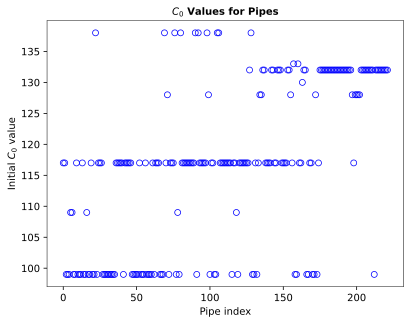

In [15]:
# Generate plot to display C_0 values for pipes only
pipe_C = [C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b', linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=10)
ax.set_ylabel(r'Initial $C_0$ value', fontsize=10)
ax.set_title('$C_0$ Values for Pipes', fontsize=10, fontweight='bold')  
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)

plt.show()

### Part 1: parameter estimation without pipe grouping + valves fixed

Based on the outcome of the initial comparison between measured and simulated heads at sensor nodes, you are tasked with the calibration of the hydraulic model of EXNING. Given the information provided by Anglian Water about the EXNING system, the first step is to adjust the pipe roughness (H-W) coefficients. In order to limit the number of parameters in question, and regardless of your answer to question 1, you will first assume (in Parts 1 and 2 of the coursework) that the status of valves is known and minor/local loss coefficients are fixed to C=0.2 (fully open).

First, you will investigate the effect of pipe grouping on the calibration of H-W coefficients. In Part 1, you will solve the model calibration problem without pipe grouping. Complete the code below to calibrate the network model using the head measurements loaded previously.

#### Separate the data into train and test datasets
We suggest you use the first day worth of data (loading conditions + $h_0$ measurements) as a train dataset, and the remaining three (3) days as a test dataset.

In [16]:
# Define the number of time steps for one day's worth of data
nt_train = 24

# train data (24 hours worth of data)
data_train = {
    'd': d_data[:, :nt_train],
    'h0': h0_data[:, :nt_train],
    'h_data': h_data[:, :nt_train]
}

# test data (three remaining days)
data_test = {
    'd': d_data[:, nt_train:],
    'h0': h0_data[:, nt_train:],
    'h_data': h_data[:, nt_train:]
}


***
**<u>Question 2:</u>** Briefly comment on the definition of the train dataset. What impact may it have on the predictive ability of your model? (i.e. what range of conditions will you confidently be able to use your model for?)

***
_A train dataset is a subset of data used to train an ML model, which will be tested on unknown data to evaluate its generalisation performance._

_Here, the train dataset is not granular enough (loading conditions + $h_0$ measurements for 24h only), which might not generalise well. We do not know ahead whether the data corresponds to a weekday, weekend or a holiday._

_Therefore, although the model could perform well for a range of conditions similar to that specific day, its ability to predict different conditions from this single day is limited and may lead to overfitting. Training a model on a limited dataset might make it too tailored to the DMA network conditions, reservoir heads, demand patterns for that specific 1st day of data._ 
***
124 words


#### Definition of the loss function
The calibration of H-W coefficients is a model fitting/parameter estimation problem. In particular, for the hydraulic model calibration problem, the loss function is defined as the mean squared error (MSE) between simulated and measured heads at sensor locations:

In [17]:
def loss_fun(h, h_data):
    return ( 1/len(h_data.flatten()) ) * np.sum( ( h[sensor_idx, :] - h_data )**2 )

Compute MSE for `C_0` values and using the training data.

In [18]:
h_0 = h_0[:, :nt_train]
mse_0 = loss_fun(h_0, data_train['h_data'])
mse_0

9.705407324726352

***
**<u>Question 3:</u>**  Justify the choice/definition of `loss_fun`.

***
_The MSE gives more importance to large errors due to the squaring of differences between the observed head values h (at specific sensor locations sensor_idx) and the predicted values h_data. It punishes the model for larger deviations of simulated pressures from reference values. We know that large deviations are most likely due to the incorrect estimation of pipe roughnesses. In turn, MSE would lead to a more accurate fitting of the H-W coefficients, and, therefore, to a better model overall. Moreover, the loss function, or the MSE, is convex, which ensures it can be combined with cvxpy as the objective function._
***
101 words

#### Solve the parameter estimation problem using the train dataset

The following function is needed for the sequential convex programming (SCP) method used in this coursework. <font color="blue">As with the `hydraulic_solver` function, we provide the following code in `linear_approx_calibration` for you to use throughout this notebook.

In [19]:
#### DO NOT CHANGE THIS ####
# compute matrices for the head loss linear approximation of the HW headloss
def linear_approx_calibration(wdn, q, C):
    # unload data
    A12 = wdn.A12
    A10 = wdn.A10
    net_info = wdn.net_info
    link_df = wdn.link_df

    K = np.zeros((net_info['np'], 1))
    n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)
    b1_k = copy.copy(K)
    b2_k = copy.copy(K)

    for idx, row in link_df.iterrows():
        if row['link_type'] == 'pipe':
            K[idx] = 10.67 * row['length'] * (C[idx] ** -row['n_exp']) * (row['diameter'] ** -4.8704)
            b1_k[idx] = copy.copy(K[idx])
            b2_k[idx] = (-n_exp[idx] * K[idx]) / C[idx]

        elif row['link_type'] == 'valve':
            K[idx] = (8 / (np.pi ** 2 * 9.81)) * (row['diameter'] ** -4) * C[idx]
            b1_k[idx] = -n_exp[idx] * copy.copy(K[idx])
            b2_k[idx] = copy.copy(K[idx]) / C[idx]

    a11_k = np.tile(K, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b1_k = np.tile(b1_k, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b2_k = np.tile(b2_k, q.shape[1]) * np.abs(q) ** (n_exp - 1) * q

    return a11_k, b1_k, b2_k

Solve the model calibration problem without pipe grouping using the `cvxpy` modelling interface. (Use the code provided previously.)

In [20]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define SCP problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 1e-4

# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = loss_fun(h_k, h_data)

# initialize a list to store MSE values at each iteration
mse_values = []

### main scp code ###
for k in range(iter_max):

    # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss)

    # compute and store the MSE at each iteration
    mse_values.append(loss_fun(h_k, h_data))

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]

    # variable bounds
    lower_bound_pipe = [theta[idx] >= C_lo_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += lower_bound_pipe
    upper_bound_pipe = [theta[idx] <= C_up_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += upper_bound_pipe

    # valve minor loss coefficient constraints
    valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += valve_constraints

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False, abstol=1e-3)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = loss_fun(h_tilde, h_data)

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 0 successful! Update estimate and increase trust region size. 

0 4.650723754163739 0.520811069689456 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 1.6535168256757358 0.6444603220745242 24.200000000000003 

Iteration 2 unsuccessful! Return to previous estimate and reduce trust region size. 

2 1.6535168256757358 0.6444603220745242 6.050000000000001 

Iteration 3 successful! Update estimate and increase trust region size. 

3 1.1967395302075254 0.27624593132370523 6.655000000000001 

Iteration 4 successful! Update estimate and increase trust region size. 

4 0.7814233567960762 0.3470397383292166 7.320500000000002 

Iteration 5 successful! Update estimate and increase trust region size. 

5 0.417923349721714 0.46517678786151617 8.052550000000002 

Iteration 6 successful! Update estimate and increase trust region size. 

6 0.25339952849304787 0.39366984720575904 8.857805000000003 

Iteration 7 successful! Update estimate and increase trust re

***
**<u>Question 4:</u>** Describe the nature/role of the different outputs of the SCP algorithm printed above (objvalk, Ki, Deltak) and explain their trends.

***
_After each iteration k, the SCP adjusts flow rates q, hydraulic heads h and the H-W coefs θ to minimize the MSE (objval_k)._ 

_<u>delta_k</u>: The algorithm uses an adaptive trust region delta_k to control how much theta can change and cautiously explore the space. A successful iteration leads to a 10% increase of delta_k, alternatively to a 75% decrease of delta_k._

_<u>objvalk</u>: The objective value objval_k indicates the model fit at iteration k. objval_k, i.e. the MSE between measured and simulated pressures, decreases as the fit improves._ 

_<u>Ki</u>: Ki is calculated as the absolute change in the objective value relative to the previous iteration's objective value. Therefore, Ki tracks the convergence of the model, set initially as infinity and guiding when to terminate the iterations when <1e-3._ 

_Below, we generate a convergence plot for the loss function against all iterations (including unsuccessful ones) until trust region delta_k is small enough to stop the SCP:_


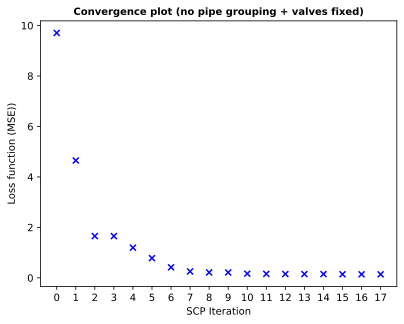

In [21]:
# create a convergence plot
plt.figure()
plt.scatter(range(len(mse_values)), mse_values, marker='x', color='b')
plt.xlabel('SCP Iteration', fontsize=10)
plt.ylabel('Loss function (MSE))', fontsize=10)
plt.title('Convergence plot (no pipe grouping + valves fixed)', fontsize=10, fontweight='bold')
# Set the x-axis ticks to integers only
plt.xticks(range(len(mse_values)))
plt.show()

***
150 words

Store the solution (i.e. new coefficients `theta_k`) as $C_1$.

In [22]:
C_1 = theta_k

In [23]:
# compute train mse
mse_train_1 = loss_fun(h_k, data_train['h_data'])
mse_train_1

0.1398310117247181

#### Evaluate test model error
Compute the MSE and plot the pressure residuals corresponding to the test dataset.

In [24]:
# compute hydraulics
_, h_test = hydraulic_solver(os.path.join(net_dir, net_name), data_test['d'], data_test['h0'], C=C_1)

# compute test mse
mse_test_1 = loss_fun(h_test, data_test['h_data'])
mse_test_1

0.14406154879895686

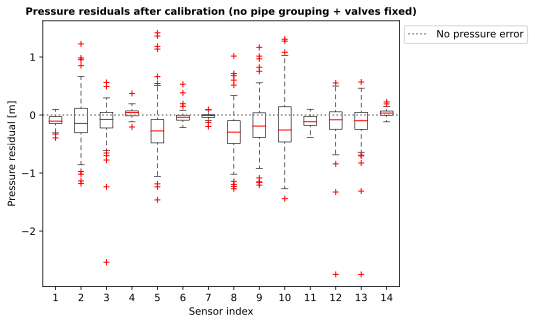

In [25]:
# Assuming h_test and data_test['h_data'] are defined and properly formatted
# Compute pressure residuals
residuals_1 = h_test[sensor_idx,:] - data_test['h_data']

# Create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_1.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=10)
ax.set_ylabel('Pressure residual [m]', fontsize=10)

# Add a dotted horizontal line at y=0 to highlight the zero residual level
ax.axhline(y=0, color='grey', linestyle='dotted', label='No pressure error')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adding the legend for the dotted line
plt.title('Pressure residuals after calibration (no pipe grouping + valves fixed)', fontsize=10, fontweight='bold')

plt.show()


***
**<u>Question 5:</u>** Comment on the improvement in model accuracy (before vs. after calibration).

***
_There is a noticeable improvement with the previous model. After calibration, the range of pressure residuals now falls within ±2m H2O as recommended by Earnshaw, (1989). Medians are also closer to 0, indicating that the predicted residual values are now closer to actual measurements. The new train MSE decreased significantly from ~9.71 to ~0.14. The calibrated H-W coefficients are also closer to their real values as there is no pipe grouping, and each pipe's roughness values are adjusted individually. However, the presence of many outliners compared to the before the calibration indicates the presence of anomalies not properly captured by the calibration. Still, only a few outliners are outside the ±2m H2O bounds (3, 12, 13), and note that this model is calibrated using test data and falls into the category of 'simulation calibration', complying with the fact that simulation-calibrated models do not require 100% of simulated pressures to be within ±2m H2O. Therefore, the model can be categorised as simulation calibrated._
***
150 words

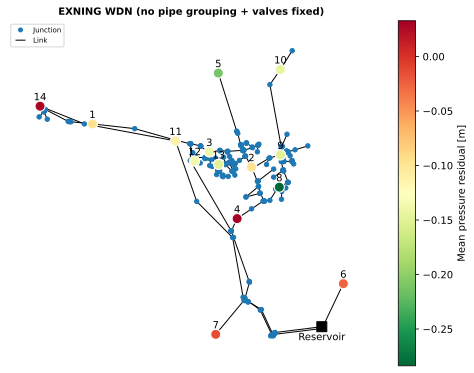

In [26]:
# Generate EXNING map after calibration - without pipe grouping + valves fixed
plt.figure()

# Create legend entries
node_legend = mlines.Line2D([], [], marker='o', linestyle='None', markersize=4, label='Junction')
link_legend = mlines.Line2D([], [], color='black', marker='_', linestyle='None', markersize=10, label='Link')

# Plot the network
mean_residuals_1 = np.mean(residuals_1, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_1)
plt.legend(handles=[node_legend, link_legend], loc='upper left', fontsize=7)

plt.title('EXNING WDN (no pipe grouping + valves fixed)', fontsize=10, fontweight='bold')
plt.show()


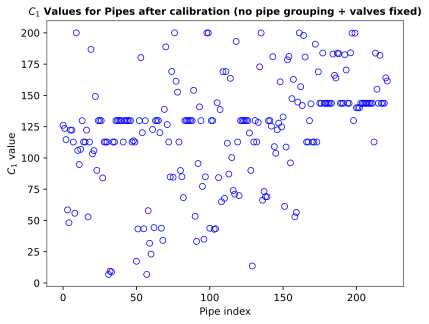

In [27]:
# C_1 value scatter plot (pipes only)
pipe_C = [C_1[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=10)
ax.set_ylabel(r'$C_1$ value', fontsize=10)
ax.set_title('$C_1$ Values for Pipes after calibration (no pipe grouping + valves fixed)', fontsize=10, fontweight='bold')  
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

***
**<u>Question 6:</u>** Comment on the values of parameter estimates in $C_1$ and explain the results of the calibration without pipe grouping. Can the new model be considered calibrated?

***
_Compared to the initial Hazen-Williams (H-W) $C_0$ values plot for pipes only, there is a higher variation in $C_1$ values after the calibration, with values now ranging from near 0 to almost 200. Without pipe grouping, the model has the freedom to estimate H-W roughness coefficients for each pipe in the network, which explains the higher spread in values $C_1$ among all pipes. Some $C_1$ values seem extreme considering that EXNING contains mostly old, cast iron pipes (100-130 range). This discrepancy arises due to the underdetermined least squares nature of the problem. With insufficient measurements to individually calibrate each pipe, multiple equally valid solutions exist. The depicted figure represents one such solution, potentially an unrealistic one. Thus, calibration with pipe grouping based on engineering knowledge is necessary to mitigate such discrepancies. To later confirm that the model is properly calibrated, it should be validated against an independent dataset not used during the calibration process._ 



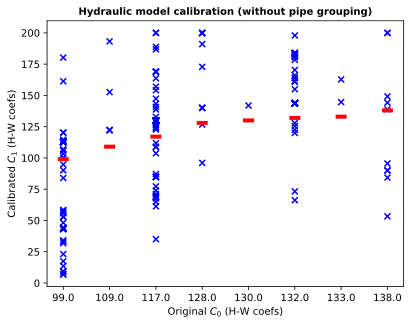

In [28]:
# Filter out 0.2 values of valves
valid_indices = np.where((C_0 != 0.2) & (C_1 != 0.2))
C_0_filtered = C_0[valid_indices]
C_1_filtered = C_1[valid_indices]

# Create a dictionary to group C_1 values by C_0 values
grouped_data = {}
for c0, c1 in zip(C_0_filtered, C_1_filtered):
    if c0 not in grouped_data:
        grouped_data[c0] = []
    grouped_data[c0].append(c1)

# Create a mapping for C_0 values to categorical x-axis positions
unique_c0_values = sorted(set(C_0_filtered))
c0_to_x = {c0_val: i for i, c0_val in enumerate(unique_c0_values)}

# Plot the data
fig, ax = plt.subplots()
for c0, c1_values in grouped_data.items():
    x = [c0_to_x[c0]] * len(c1_values)  # Use mapped x position for the group
    y = c1_values
    ax.scatter(x, y, marker='x', color='b')  # Blue crosses for C_1
    ax.scatter(c0_to_x[c0], c0, color='red', marker='_', s=120, linewidths=4)  # Red dash for the group mean

# Set the x-axis ticks and labels to reflect the original C_0 values
ax.set_xticks(range(len(unique_c0_values)))
ax.set_xticklabels([f'{c0:.1f}' for c0 in unique_c0_values])

ax.set_xlabel(r'Original $C_0$ (H-W coefs)', fontsize=10)
ax.set_ylabel(r'Calibrated $C_1$ (H-W coefs)', fontsize=10)
ax.set_title('Hydraulic model calibration (without pipe grouping)', fontsize=10, fontweight='bold')
plt.show()

_Above, we visualise the spread between the values of the calibrated $C_1$ H-W coefs without pipe grouping against the original assumed $C_0$ H-W values before calibration, where all pipes belonging to the same group were assigned the same H-W value._
***
148 words

### Part 2: parameter estimation with pipe grouping + valves fixed
In order to reduce the underdeterminedness of the model calibration problem (and improve the quality of estimated H-W coefficients), pipes can be grouped based on their material and age. In particular, all pipes of a group are assumed to share the same H-W coefficient. This also allows tighter bounds on the grouped coefficient estimates (stored in $\Theta_{\text{lb}}$ and $\Theta_{\text{ub}}$, for lower and upper bounds, respectively) in the formulation of the parameter estimation problem. Here, you will still assume the status of valves is known with minor/local loss coefficients fixed to C=0.2. Use the code provided in Week 5 and modify as necessary below to calibrate the hydraulic model with pipe grouping, using the same train data as before. (Note that Part 2 might take a little longer to run than Part 1.)

Load pipe grouping information.

In [29]:
link_groups = data['G'][0] - 1 # matlab to python index offset
ng = link_groups.shape[0]
thetaG_lo = data['thetaG_min'][:, 0]
thetaG_up = data['thetaG_max'][:, 0]

#### Solve the parameter estimation problem using the train dataset
Solve the model calibration problem with pipe grouping. (Use the code provided previously and modify as necessary.)

In [30]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20

# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = loss_fun(h_k, h_data)

# initialize a list to store MSE values at each iteration
mse_values = []

### main scp code ###
for k in range(iter_max):

     # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])
    thetaG = cp.Variable(ng)

    # objective function
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss)

    # compute and store the MSE at each iteration
    mse_values.append(loss_fun(h_k, h_data))

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]
    
    # pipe grouping constraints
    for j in range(ng):
        
        # equality constraints
        for idx in link_groups[j]:
            constraints += [
                theta[idx] == thetaG[j]
            ]
            
        # pipe grouping bounds
        constraints += [
            thetaG[j] >= thetaG_lo[j],
            thetaG[j] <= thetaG_up[j]
        ]

    # valve minor loss coefficient constraints
    valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += valve_constraints

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False, abstol=1e-3)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    thetaG_tilde = thetaG.value
    q_tilde, h_tilde = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = loss_fun(h_tilde, h_data)

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        # thetaG_k = thetaG_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 0 successful! Update estimate and increase trust region size. 

0 4.74299273472141 0.5113041033694955 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 3.7299788151701594 0.2135811661981709 24.200000000000003 

Iteration 2 unsuccessful! Return to previous estimate and reduce trust region size. 

2 3.7299788151701594 0.2135811661981709 6.050000000000001 

Iteration 3 unsuccessful! Return to previous estimate and reduce trust region size. 

3 3.7299788151701594 0.2135811661981709 1.5125000000000002 

Iteration 4 unsuccessful! Return to previous estimate and reduce trust region size. 

4 3.7299788151701594 0.2135811661981709 0.37812500000000004 

Iteration 5 unsuccessful! Return to previous estimate and reduce trust region size. 

5 3.7299788151701594 0.2135811661981709 0.09453125000000001 



Below, we generate a convergence plot for the loss function against all iterations (including unsuccessful ones) until trust region is small enough to stop the SCP.

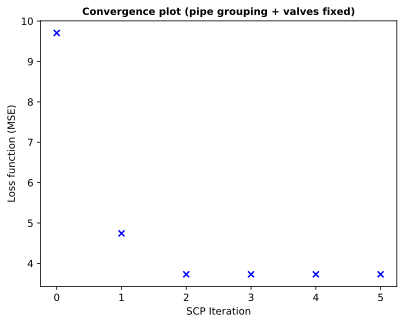

In [31]:
# create a convergence plot
plt.figure()
plt.scatter(range(len(mse_values)), mse_values, marker='x', color='b')
plt.xlabel('SCP Iteration')
plt.ylabel('Loss function (MSE)')
plt.title('Convergence plot (pipe grouping + valves fixed)', fontsize=10, fontweight='bold')
plt.show()

Store the solution (i.e. new coefficients `theta_k`) as $C_2$.

In [32]:
C_2 = theta_k

In [33]:
# see how many groups (8 pipes + 1 valves)
C2groups = list(set(np.round(C_2, 3)))
C2groups

[0.2, 103.0, 74.0, 107.0, 108.967, 108.0, 113.0, 118.327, 92.0]

In [34]:
# compute train mse
mse_train_2 = loss_fun(h_k, data_train['h_data'])
mse_train_2

3.7299788151701594

#### Evaluate test model error
Compute the MSE and plot the pressure residuals corresponding to the test dataset.

In [35]:
# compute hydraulics
_, h_test = hydraulic_solver(os.path.join(net_dir, net_name), data_test['d'], data_test['h0'], C=C_2)

# compute test mse
mse_test_2 = loss_fun(h_test, data_test['h_data'])
mse_test_2

3.5152394487182357

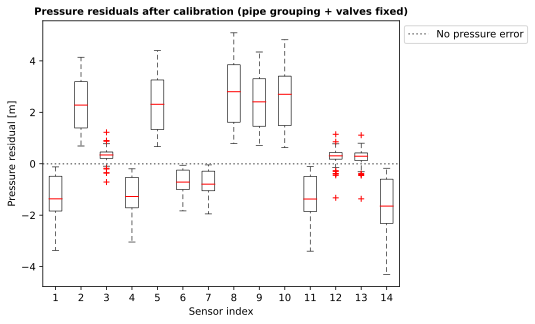

In [36]:
# compute pressure residuals
residuals_2 = h_test[sensor_idx,:] - data_test['h_data']

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_2.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=10)
ax.set_ylabel('Pressure residual [m]', fontsize=10)

# Add a dotted horizontal line at y=0 to highlight the zero residual level
ax.axhline(y=0, color='grey', linestyle='dotted', label='No pressure error')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adding the legend for the dotted line
plt.title('Pressure residuals after calibration (pipe grouping + valves fixed)', fontsize=10, fontweight='bold')

plt.show()


***
**<u>Question 7:</u>** Comment on the improvement in model accuracy after calibration with pipe grouping.

***
_Pipes within each group are now assigned the same H-W coefficient, which constrains the solution space and improves the model's robustness by reducing the instances of outliners. Comparing to the previous calibration, a few outliers remain at sensors 3, 12, 13 and are within ±2m H2O, which suggests that grouping helped to mitigate the impact of anomalies that do not fit well with the general model. Also, we notice a balanced distribution of residuals from one side and the other of the zero pressure line, suggesting that the model is equally likely to overpedict as it is to underpredict pressure heads, which is a characteristic of a robust model. However, the train MSE increased to ~3.7, and, for most of the sensors (except 3, 12, 13), the medians appear to be further away from zero and the ranges of residuals are somewhat wider. While the model is more stable, it is not as accurate across all sensor locations and can not be considered calibrated._
***
150 words

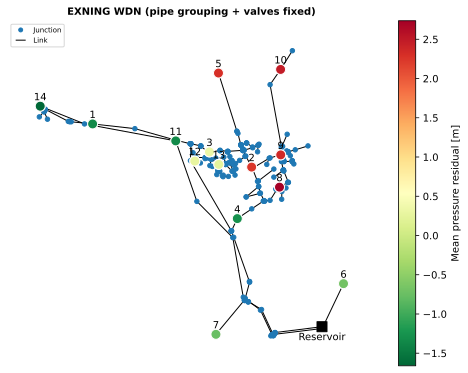

In [37]:
# generate EXNING map after calibration - with pipe grouping + valves fixed
plt.figure()

# create legend entries
node_legend = mlines.Line2D([], [], marker='o', linestyle='None', markersize=4, label='Junction')
link_legend = mlines.Line2D([], [], color='black', marker='_', linestyle='None', markersize=10, label='Link')

# plot the network
mean_residuals_2 = np.mean(residuals_2, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_2)
plt.legend(handles=[node_legend, link_legend], loc='upper left', fontsize=7)

plt.title('EXNING WDN (pipe grouping + valves fixed)', fontsize=10, fontweight='bold')
plt.show()

#### Discuss the values of the calibrated H-W coefficients $C_2$
Visualise the values of newly calibrated coefficients $C_2$ compared to model coefficients $C_1$ and $C_0$.

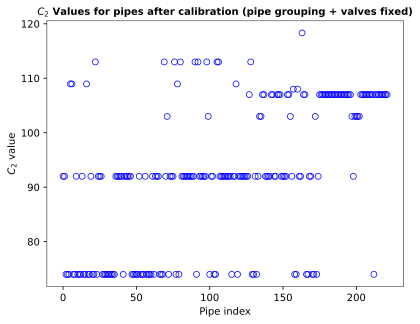

In [38]:
# C_2 value scatter plot (pipes only)
pipe_C = [C_2[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=10)
ax.set_ylabel('$C_2$ value', fontsize=10)
ax.set_title('$C_2$ Values for pipes after calibration (pipe grouping + valves fixed)', fontsize=10, fontweight='bold')  
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

***
**<u>Question 8:</u>** Comment on the values of the H-W coefficient estimates $C_2$ and justify the results of the calibration with pipe grouping.

***
_Compared to $C_1$ where pipes are unrestrained to take any value (np decision variables, but within C_lo_pipe=0 and C_up_pipe=200), the $C_2$ values are grouped along a discrete set of 8 values, within a smaller range of 70 to 120. The coefficients are now constrained within a more realistic and physically plausible range than for the $C_1$ without grouping, and in line with typical roughness coefficients for cast iron pipes. Although the MSE increased as noted above, the grouping reduced the underterminedness of the model and the variability in estimated H-W coefficients throughout the network. This likely has reduced the potential for overfitting, meaning that the model is now likely better capturing the underlying hydraulic behavior of the system. Calibration with grouping may also have improved the model's ability to fit to new data for that same network._

We visualise below a comparison between $C_1$ and $C_2$ values.

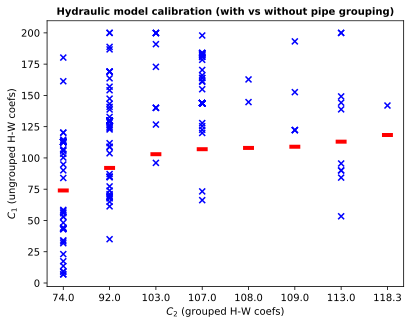

In [39]:
# filter out 0.2 values of valves
valid_indices = np.where((np.round(C_2, 3) != 0.2) & (np.round(C_1,3) != 0.2))
C_2_filtered = np.round(C_2[valid_indices], 3)
C_1_filtered = C_1[valid_indices]

# create a dictionary to group C_1 values by C_2 values
grouped_data = {}
for c2, c1 in zip(C_2_filtered, C_1_filtered):
    if c2 not in grouped_data:
        grouped_data[c2] = []
    grouped_data[c2].append(c1)

# create a mapping for C_2 values to categorical x-axis positions
unique_c2_values = sorted(set(C_2_filtered))
c2_to_x = {c2_val: i for i, c2_val in enumerate(unique_c2_values)}

# plot the data
fig, ax = plt.subplots()
for c2, c1_values in grouped_data.items():
    x = [c2_to_x[c2]] * len(c1_values)  # Use mapped x position for the group
    y = c1_values
    ax.scatter(x, y, marker='x', color='b')  # Blue crosses for C_1
    ax.scatter(c2_to_x[c2], c2, color='red', marker='_', s=120, linewidths=4)  # Red dash for the group mean

# set the x-axis ticks and labels to reflect the original C_2 values
ax.set_xticks(range(len(unique_c2_values)))
ax.set_xticklabels([f'{c2:.1f}' for c2 in unique_c2_values])

ax.set_xlabel(r'$C_2$ (grouped H-W coefs)', fontsize=10)
ax.set_ylabel(r'$C_1$ (ungrouped H-W coefs)', fontsize=10)
ax.set_title('Hydraulic model calibration (with vs without pipe grouping)', fontsize=10, fontweight='bold')
plt.show()


***
137 words

***
**<u>Question 9:</u>** Can the newly calibrated model (with H-W coefficients in $C_2$) be considered calibrated? Considering the results of Part 2, as well as your answer to question 1, provide an interpretation of the remaining pressure/head residuals.

***

_Although the newly calibrated model shows a more realistic range of $C_2$ values, it can not be considered calibrated. Compared to the initial residuals for $C_0$, we note that the range of residuals no longer falls within ±2m H2O. In part 1, although H-W coefficients had a larger range (from 0 to 200), the boxplot complied with the hydraulic guidelinesthe and the MSEs were smaller, indicating smaller differences between simulated and measured heads. However, these were unrealistic compared to the true H-W values for cast iron pipes. The increase in the pressure residual range in part 2 could be attributed to the assumption of fixed minor loss coefficients. In the network, all valves are set to be open, as suggested by Cml=0.2, disregarding possible effects of minor losses. Also, it assumes that all valves are of similar condition, which is a simplification. To further calibrate the model, allowing valve coefficients to vary is recommended._
***
150 words

### Part 3: parameter estimation with pipe grouping + valve coefficients free

Following initial reports concerning discrepancies in the EXNING model, AW were able to confirm that:
* flow and head sensors had been calibrated before collection of load/field data corresponding to the train and test datasets,
* allocation of demands in the train and test dataset is representative of normal network conditions and based on recent demand monitoring campaigns (incl. of large industrial users), and
* boundary valves (isolating EXNING from adjacent DMAs) are closed.

As a result, the remaining deviations between measured and simulated pressures must result from unknown/unreported changes in system connectivity. Errors associated with unknown valve status (e.g. closed valves) can be identified by solving a similar parameter estimation problem where valve coefficients, in addition to H-W coefficients, are free to vary.

In Part 3, you are encouraged to propose and investigate an approach to calibrate the hydraulic model with unknown valve coefficients. You may follow the suggested steps below, or come up with your own. Marks will be allocated based on the justification of the adopted approach (show your thinking!) and discussion of the obtained results in question 10, whether they lead to a firm conclusion about the existence/location of unknowingly closed valves or not.

Suggested approach:
1. Try modifying the CVXPY implementation in Part 2 to allow valve coefficients to vary. Solve the resulting parameter estimation problem and interpret the optimal value of $C_3$.
2. Next, try further modifying your CVXPY implementation to account for the expected sparsity of large valve coefficients (hint: you might want to consider regularising your problem formulation). Solve the resulting problem and comment on the optimal value of $C_3$.
3. Finally, compare the results of Part 3 with your answer to question 1 and preliminary model evaluation. Explain whether they contradict or corroborate your previous conclusions about the most likely sources of error in the EXNING model by answering question 10 below.

## Part 3.1 Pipe grouping + Free valve coefficients
We modify the code in Part 2. to allow valve coefficients to vary within bounds 0 and 5000

In [40]:
link_groups = data['G'][0] - 1 # matlab to python index offset
ng = link_groups.shape[0]
thetaG_lo = data['thetaG_min'][:, 0]
thetaG_up = data['thetaG_max'][:, 0]

# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define problem parameters
Ki = np.inf 
iter_max = 50
delta_k = 20
C_lo_valve = 0.2
C_up_valve = 5e3

# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = loss_fun(h_k, h_data)

# Initialize a list to store MSE values at each iteration
mse_values = []

### main scp code ###
for k in range(iter_max):

    # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])
    thetaG = cp.Variable(ng)

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss)

    # Compute and store the MSE at each iteration
    mse_values.append(loss_fun(h_k, h_data))

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]
    
    # pipe grouping constraints
    for j in range(ng):
        
        # equality constraints
        for idx in link_groups[j]:
            constraints += [
                theta[idx] == thetaG[j]
            ]
            
        # pipe grouping bounds
        constraints += [
            thetaG[j] >= thetaG_lo[j],
            thetaG[j] <= thetaG_up[j]
        ]

     # C bounds
    lower_bound_valve = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += lower_bound_valve
    upper_bound_valve = [theta[idx] <= C_up_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += upper_bound_valve

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    thetaG_tilde = thetaG.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = loss_fun(h_tilde, h_data)

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        thetaG_k = thetaG_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 0 successful! Update estimate and increase trust region size. 

0 2.664580610638627 0.7254540153250337 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 1.6873992489804828 0.36672989278561957 24.200000000000003 

Iteration 2 successful! Update estimate and increase trust region size. 

2 1.3801024540134474 0.1821126773362631 26.620000000000005 

Iteration 3 successful! Update estimate and increase trust region size. 

3 1.1950544321642698 0.13408281487439092 29.282000000000007 

Iteration 4 successful! Update estimate and increase trust region size. 

4 1.0323835596106847 0.136120052924271 32.21020000000001 

Iteration 5 successful! Update estimate and increase trust region size. 

5 0.8764909266345882 0.15100263029651906 35.43122000000001 

Iteration 6 successful! Update estimate and increase trust region size. 

6 0.7275436662350492 0.1699358839588257 38.974342000000014 

Iteration 7 successful! Update estimate and increase trust region size

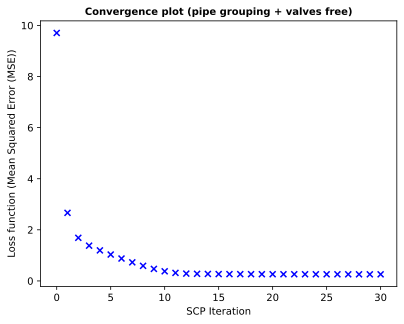

In [41]:
# Create a convergence plot
plt.figure()
plt.scatter(range(len(mse_values)), mse_values, marker='x', color='b')
plt.xlabel('SCP Iteration')
plt.ylabel('Loss function (Mean Squared Error (MSE))')
plt.title('Convergence plot (pipe grouping + valves free)', fontsize=10, fontweight='bold')
plt.show()

In [42]:
C_3a = theta_k

# compute train mse
mse_train_3a = loss_fun(h_k, data_train['h_data'])
mse_train_3a

0.25797245643031713

In [43]:
# compute hydraulics
_, h_test = hydraulic_solver(os.path.join(net_dir, net_name), data_test['d'], data_test['h0'], C=C_3a)

# compute test mse
mse_test_3a = loss_fun(h_test, data_test['h_data'])
mse_test_3a

0.26677215823114164

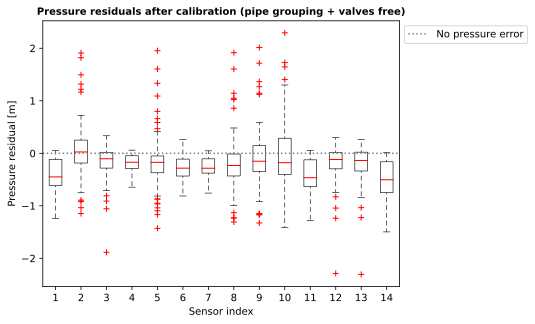

In [44]:
# compute pressure residuals
residuals_3a = h_test[sensor_idx,:] - data_test['h_data']

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_3a.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=10)
ax.set_ylabel('Pressure residual [m]', fontsize=10)

# Add a dotted horizontal line at y=0 to highlight the zero residual level
ax.axhline(y=0, color='grey', linestyle='dotted', label='No pressure error')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) # Adding the legend for the dotted line
plt.title('Pressure residuals after calibration (pipe grouping + valves free)', fontsize=10, fontweight='bold')

plt.show()

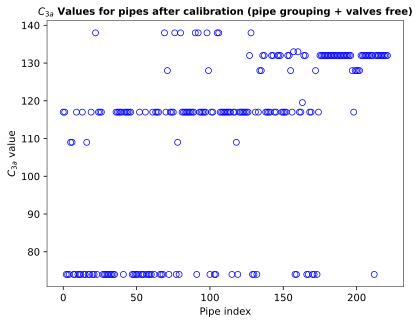

In [45]:
# C_3a value scatter plot (pipes)
pipe_C = [C_3a[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=10)
ax.set_ylabel(r'$C_{3a}$ value', fontsize=10)
ax.set_title(r'$C_{3a}$ Values for pipes after calibration (pipe grouping + valves free)', fontsize=10, fontweight='bold')  
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

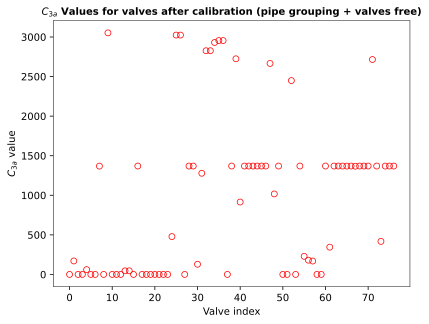

In [46]:
# C_3a value scatter plot (valves)
valve_C = [C_3a[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(range(len(valve_C)), valve_C, facecolors='none', edgecolors='r',linewidths=0.75)
ax.set_xlabel('Valve index', fontsize=10)
ax.set_ylabel(r'$C_{3a}$ value', fontsize=10)
ax.set_title(r'$C_{3a}$ Values for valves after calibration (pipe grouping + valves free)', fontsize=10, fontweight='bold')  
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

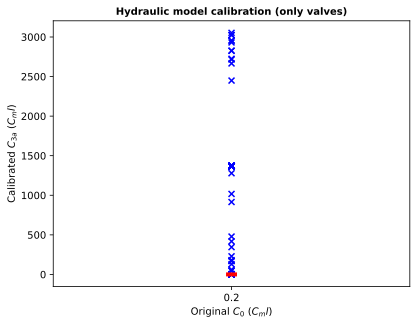

In [47]:
C_0_v=[C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
C_3a_v=[C_3a[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']

# Create a dictionary to group C_3a values by C_0 values
grouped_data = {}
for c0, c3a in zip(C_0_v, C_3a_v):
    if c0 not in grouped_data:
        grouped_data[c0] = []
    grouped_data[c0].append(c3a)

# Create a mapping for C_0 values to categorical x-axis positions
unique_c0_values = sorted(set(C_0_v))
c0_to_x = {c0_val: i for i, c0_val in enumerate(unique_c0_values)}

# Plot the data
fig, ax = plt.subplots()
for c0, c3a_values in grouped_data.items():
    x = [c0_to_x[c0]] * len(c3a_values)  # Use mapped x position for the group
    y = c3a_values
    ax.scatter(x, y, marker='x', color='b')  # Blue crosses for C_3a
    ax.scatter(c0_to_x[c0], c0, color='red', marker='_', s=120, linewidths=4)  # Red dash for the group mean

# Set the x-axis ticks and labels to reflect the original C_0 values
ax.set_xticks(range(len(unique_c0_values)))
ax.set_xticklabels([f'{c0:.1f}' for c0 in unique_c0_values])

ax.set_xlabel(r'Original $C_0$ ($C_ml$)', fontsize=10)
ax.set_ylabel(r'Calibrated $C_{3a}$ ($C_ml$)', fontsize=10)
ax.set_title('Hydraulic model calibration (only valves)', fontsize=10, fontweight='bold')
plt.show()


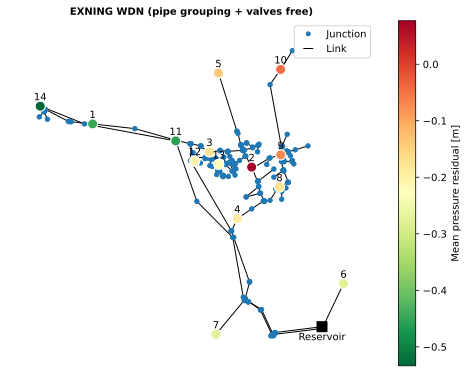

In [48]:
# Generate EXNING map after calibration - with pipe grouping + valves fixed
plt.figure()

# Create legend entries
node_legend = mlines.Line2D([], [], marker='o', linestyle='None', markersize=4, label='Junction')
link_legend = mlines.Line2D([], [], color='black', marker='_', linestyle='None', markersize=10, label='Link')

# Plot the network
mean_residuals_3a = np.mean(residuals_3a, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_3a)
plt.legend(handles=[node_legend, link_legend], loc='best')

plt.title('EXNING WDN (pipe grouping + valves free)', fontsize=10, fontweight='bold')
plt.show()

## Part 3.2: Incorporation of a Lasso Regression

Lasso regression employs the L1 norm, whereas Ridge regression utilizes the L2 norm. The key distinction in their impact on the hydraulic model's output lies in how they treat parameter values. The L1 norm, as seen in Lasso regression, encourages sparsity among parameters, allowing one parameter estimate to compensate for another. In contrast, the L2 norm, as used in Ridge regression, promotes small values for all parameter indices, with no significant compensation between them.

In the context of this model, opting for the L1 norm appears more appropriate due to the ample data measurements available. It is expected that certain components will exhibit substantial variations in magnitude. To maintain the integrity of the objective function, the L1 norm, by encouraging sparsity in parameter estimates, seems better suited. Given the nature of the data, which can exhibit non-uniform values for pipes and valves due to varying flow conditions, pipe age, and material properties across the 
DMA, employing the L2 squared norm would be less suitable. 

Below, we define a range of hyperparameters lambda values to test. If lambda is too large, the model might oversimplify and miss important details; if lambda is too small, the model might overfit to the noise in the data. 

We introduce an outer loop that iterates through a predefined set of lambda values and records the average performance of the model for each lambda (MSE). After the loop, it selects the lambda with the best performance (lowest MSE).

In [57]:
# we can use a logarithmic scale when dealing with regularization parameters.
lam_values = np.logspace(0, -3, 3)

# initialize a dictionary to store the performance for each lam
performance_for_lam = {}

# initialize a dictionary to store MSE values for each lam and each iteration
mse_values_per_lam = {lam: [] for lam in lam_values}

In [58]:
# outer loop to test each lam value
for lam in lam_values:

    # update the valve regularization function with the current lam
    valve_idx = link_df.index[link_df['link_type'] == 'valve'].tolist()
    def valve_reg_fun(theta):
        return lam * (1 / len(valve_idx)) * la.norm(C_0[valve_idx] - theta[valve_idx], 1)

    # unload network training data
    n_exp = link_df['n_exp']
    d = data_train['d']
    h_data = data_train['h_data']
    h0 = data_train['h0'].reshape(-1, 1).T

    # define problem parameters
    Ki = np.inf 
    iter_max = 50
    delta_k = 20
    C_lo_valve = 0.2
    C_up_valve = 5e3

    # initialise values
    theta_k = C_0
    q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
    a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
    objval_k = loss_fun(h_k, h_data) + valve_reg_fun(theta_k)

    # initialize performance metric for the current lam
    performance_for_lam[lam] = []

    # initialize a list to store MSE values at each iteration
    mse_values = []


    ### main scp code ###
    for k in range(iter_max):

        # decision variables
        q = cp.Variable((net_info['np'], nt_train))
        h = cp.Variable((net_info['nn'], nt_train))
        theta = cp.Variable(net_info['np'])
        thetaG = cp.Variable(ng)

        # objective function 
        loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
        valve_reg = lam * (1 / len(valve_idx)) * cp.norm(C_0[valve_idx] - theta[valve_idx], 1)
        objective = cp.Minimize(loss + valve_reg)

        # compute and store the MSE at each iteration
        mse_values.append(loss_fun(h_k, h_data))
        
        # compute the current MSE and store it for the current lam
        mse_current = loss_fun(h_k, h_data)
        mse_values_per_lam[lam].append(mse_current)


        # hydraulic feasibility constraints
        constraints = []
        for t in range(nt_train):
            # energy and mass constraints
            constraints += [
                cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
                A12.T @ q[:, t] == d[:, t]
            ]

        # trust region constraints
        constraints += [
            cp.norm(theta - theta_k, 'inf') <= delta_k
        ]
        
        # pipe grouping constraints
        for j in range(ng):
            
            # equality constraints
            for idx in link_groups[j]:
                constraints += [
                    theta[idx] == thetaG[j]
                ]
                
            # pipe grouping bounds
            constraints += [
                thetaG[j] >= thetaG_lo[j],
                thetaG[j] <= thetaG_up[j]
            ]

        # C bounds
        lower_bound_valve = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
        constraints += lower_bound_valve
        upper_bound_valve = [theta[idx] <= C_up_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
        constraints += upper_bound_valve

        # solve optimisation problem
        problem = cp.Problem(objective, constraints)
        cvx_val = problem.solve(solver=cp.ECOS, verbose=False, abstol=1e-3)

        # store optimal solution and compute actual and predicted decrease in objval
        theta_tilde = theta.value
        thetaG_tilde = thetaG.value
        [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
        objval_tilde = loss_fun(h_tilde, h_data) + valve_reg_fun(theta_tilde)

        predicted_decrease = objval_k - cvx_val
        actual_decrease = objval_k - objval_tilde

        # evaluate latest SCP iteration
        if actual_decrease / predicted_decrease >= 0.1:
            objval_old = objval_k
            theta_k = theta_tilde
            thetaG_k = thetaG_tilde
            q_k = q_tilde
            h_k = h_tilde
            objval_k = objval_tilde
            a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
            Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
            delta_k = 1.1 * delta_k
            print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

        else:
            delta_k = 0.25 * delta_k
            print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

        print(f"{k} {objval_k} {Ki} {delta_k} \n")

        if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:

            # store mse when convergence happens
            performance_for_lam[lam].append(loss_fun(h_k, h_data))
            break


# find the lam with the best performance
best_lam = min(performance_for_lam, key=performance_for_lam.get)
print(f"Dictionary of lambda values & MSE: {performance_for_lam}")
print(f"The best lam value is {best_lam}")

Iteration 0 successful! Update estimate and increase trust region size. 

0 4.348663004118751 0.5519340035281453 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 3.368159713213915 0.22547235552080525 24.200000000000003 

Iteration 2 successful! Update estimate and increase trust region size. 

2 3.3628155160333053 0.001586681640910126 26.620000000000005 

Iteration 3 unsuccessful! Return to previous estimate and reduce trust region size. 

3 3.3628155160333053 0.001586681640910126 6.655000000000001 

Iteration 4 successful! Update estimate and increase trust region size. 

4 3.362395850570888 0.0001247958624004879 7.320500000000002 

Iteration 0 successful! Update estimate and increase trust region size. 

0 2.826219016773126 0.708799546251624 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 1.9337697629029718 0.3157749801319787 24.200000000000003 

Iteration 2 successful! Update estimate and increase trust region size

Below, we create a visualisation of the converging behaviour of the model for the different hyperparameters lambda. 

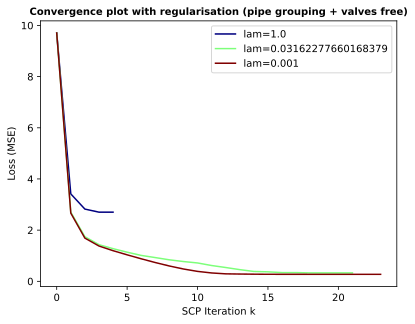

In [76]:
# assume mse_values_per_lam is already populated with MSE values
# define the colormap
colors = cm.jet(np.linspace(0, 1, len(lam_values)))

# plotting the MSE for each lam value with different colors from the 'jet' colormap
for i, lam in enumerate(lam_values):
    plt.plot(mse_values_per_lam[lam], label=f'lam={lam}', color=colors[i])

plt.xlabel('SCP Iteration k')
plt.ylabel('Loss (MSE)')
plt.title('Convergence plot with regularisation (pipe grouping + valves free)', fontsize=10, fontweight='bold')
plt.legend()
plt.show()

Below, the chosen lambda is selected for the convergence plot. 

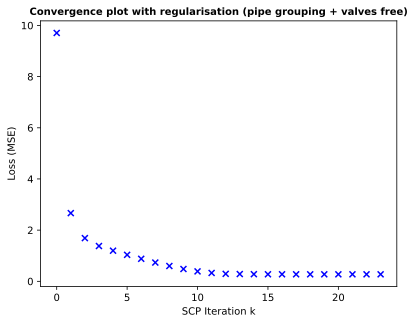

In [60]:
# create a convergence plot for best lambda value
# select best array of mse values for a given lambda
selected_mse_vals=mse_values_per_lam[best_lam]

plt.figure()
plt.scatter(range(len(selected_mse_vals)), selected_mse_vals, marker='x', color='b')
plt.xlabel('SCP Iteration k')
plt.ylabel('Loss (MSE)')
plt.title('Convergence plot with regularisation (pipe grouping + valves free)', fontsize=10, fontweight='bold')
plt.show()

In [61]:
C_3b = theta_k

In [62]:
# compute train mse
mse_train_3b = loss_fun(h_k, data_train['h_data'])
mse_train_3b

0.2734273950770876

In [63]:
# compute hydraulics
_, h_test = hydraulic_solver(os.path.join(net_dir, net_name), data_test['d'], data_test['h0'], C=C_3b)

# compute test mse
mse_test_3b = loss_fun(h_test, data_test['h_data'])
mse_test_3b

0.27842595445297175

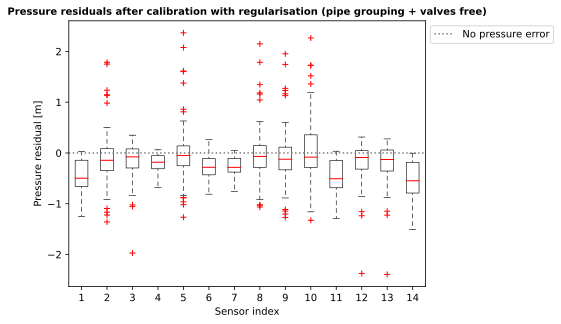

In [64]:
# compute pressure residuals
residuals_3b = h_test[sensor_idx,:] - data_test['h_data']

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_3b.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=10)
ax.set_ylabel('Pressure residual [m]', fontsize=10)

# Add a dotted horizontal line at y=0 to highlight the zero residual level
ax.axhline(y=0, color='grey', linestyle='dotted', label='No pressure error')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adding the legend for the dotted line
plt.title('Pressure residuals after calibration with regularisation (pipe grouping + valves free)', fontsize=10, fontweight='bold')

plt.show()

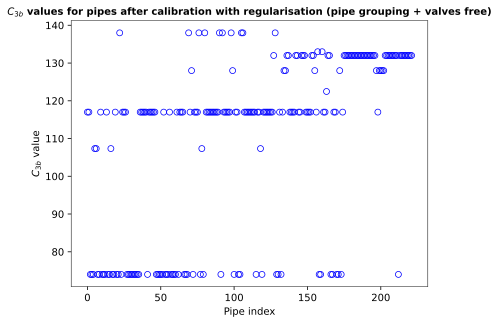

In [65]:
# C_3b value scatter plot (pipes)
pipe_C = [C_3b[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=10)
ax.set_ylabel(r'$C_{3b}$ value', fontsize=10)
ax.set_title(r'$C_{3b}$ values for pipes after calibration with regularisation (pipe grouping + valves free)', fontsize=10, fontweight='bold')  

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
    

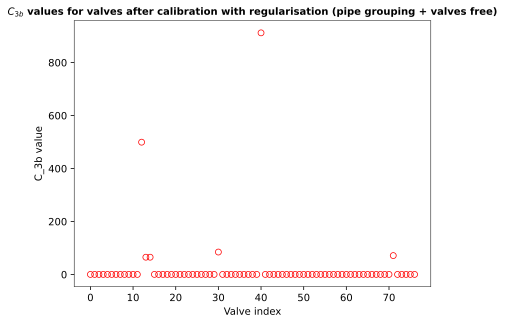

In [66]:
# C_3b value scatter plot (valves)
valve_C = [C_3b[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(range(len(valve_C)), valve_C, facecolors='none', edgecolors='r',linewidths=0.75)
ax.set_xlabel('Valve index', fontsize=10)
ax.set_ylabel('C_3b value', fontsize=10)
ax.set_title(r'$C_{3b}$ values for valves after calibration with regularisation (pipe grouping + valves free)', fontsize=10, fontweight='bold')  
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

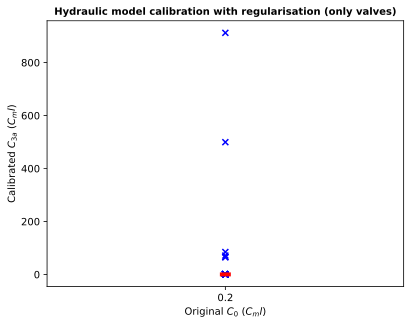

In [75]:
C_0_v = [C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
C_3b_v = [C_3b[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']

# create a dictionary to group C_3b values by C_0 values
grouped_data = {}
for c0, c3b in zip(C_0_v, C_3b_v):
    if c0 not in grouped_data:
        grouped_data[c0] = []
    grouped_data[c0].append(c3b)

# create a mapping for C_0 values to categorical x-axis positions
unique_c0_values = sorted(set(C_0_v))
c0_to_x = {c0_val: i for i, c0_val in enumerate(unique_c0_values)}

# plot the data
fig, ax = plt.subplots()
for c0, c3b_values in grouped_data.items():
    x = [c0_to_x[c0]] * len(c3b_values)  # use mapped x position for the group
    y = c3b_values
    ax.scatter(x, y, marker='x', color='b')  # blue crosses for C_3b
    ax.scatter(c0_to_x[c0], c0, color='red', marker='_', s=120, linewidths=4)  # red dash for the group mean

# set the x-axis ticks and labels to reflect the original C_0 values
ax.set_xticks(range(len(unique_c0_values)))
ax.set_xticklabels([f'{c0:.1f}' for c0 in unique_c0_values])

ax.set_xlabel(r'Original $C_0$ ($C_ml$)', fontsize=10)
ax.set_ylabel(r'Calibrated $C_{3a}$ ($C_ml$)', fontsize=10)
ax.set_title('Hydraulic model calibration with regularisation (only valves)', fontsize=10, fontweight='bold')
plt.show()


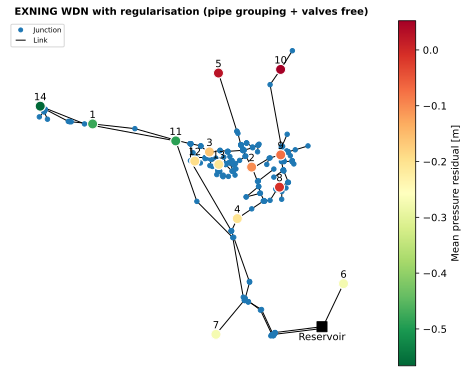

In [68]:
# cenerate EXNING map after calibration - with pipe grouping + valves fixed
plt.figure()

# create legend entries
node_legend = mlines.Line2D([], [], marker='o', linestyle='None', markersize=4, label='Junction')
link_legend = mlines.Line2D([], [], color='black', marker='_', linestyle='None', markersize=10, label='Link')

# plot the network
mean_residuals_3b = np.mean(residuals_3b, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_3b)
plt.legend(handles=[node_legend, link_legend], loc='upper left', fontsize=7)

plt.title('EXNING WDN with regularisation (pipe grouping + valves free)', fontsize=10, fontweight='bold')
plt.show()

In [74]:
# find indices of faulty valves and corresponding downstream nodes
valve_C = [idx for idx in valve_idx if C_3b[idx] > 300]
valve_nodes = link_df.loc[valve_C, 'node_out'].tolist()
valve_nodes

['node_0090', 'node_0111']

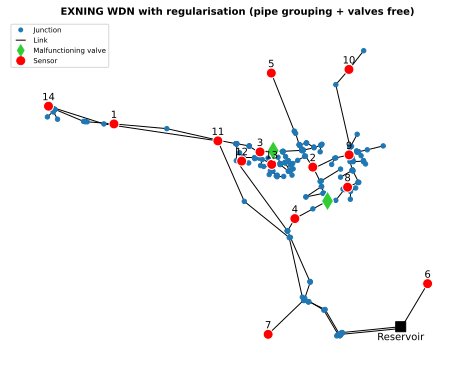

In [70]:
# generate EXNING map after calibration - with pipe grouping + valves fixed
plt.figure()

# create legend entries
node_legend = mlines.Line2D([], [], marker='o', linestyle='None', markersize=4, label='Junction')
sensor_legend = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Sensor')
link_legend = mlines.Line2D([], [], color='black', marker='_', linestyle='None', markersize=10, label='Link')
valve_legend = mlines.Line2D([], [], color='limegreen', marker='d', linestyle='None', markersize=8, label='Malfunctioning valve')

# plot the network
plot_network(wdn, sensor_idx, highlight_valves=valve_nodes)
plt.legend(handles=[node_legend,link_legend, valve_legend, sensor_legend], loc='upper left', fontsize=7)

plt.title('EXNING WDN with regularisation (pipe grouping + valves free)', fontsize=10, fontweight='bold')
plt.show()

***
**<u>Question 10:</u>** Summarise your findings and provide recommendations to AW to validate your proposed hydraulic model update. Provide plots to support your recommendations.
***
In Part 1 residuals adhered to the regulations for all sensors. However, the model calibration yielded unrealistic H-W coefficients. This led to coefficients that were unrealistic, especially in comparison to the typical H-W coefficients associated with Cast Iron pipes. Likely sources of error in Part 1. include the unrealistic bounds for theta, the absence of pipe grouping, and the use of constant minor loss coefficients Cml of 0.2 for all valves (open).

In Part 3, we group pipes and allowed the minor loss coefficients for valves to vary, and later introduced a L1 regularisation to the model. The model remained uncalibrated as it failed to conform to the 2-meter pressure residual range. But, H-W coefficients obtained in Part 3 were more realistic and reliable, aligning with typical Cast Iron pipe coefficients. We detect two malfunctioning valves at ['node_0090', 'node_0111'], which have a Cml>300.

We propose several recommendations:

- Grouping of valves into specific types (e.g., globe, angle, gate)
- Collection of field data specific to valves for better constraints
- Incorporation of minor loss data for fittings, bends, and valves
- Consideration of the model's assumption of steady-state conditions
***
179 words > 150

**References**

Earnshaw, F. (1989). Network analysis: A code of practice. WRc.

Hall, J. W. (2003). Handling uncertainty in the hydroinformatic process. Journal of Hydroinformatics, 5(4), 215–232. https://doi.org/10.2166/hydro.2003.0019

